In [118]:
import sys, os
from glob import glob
import json
import numpy as np
from scipy.ndimage import gaussian_filter1d as gf1
from fastspt import simulate, bayes, swift, version, readers, timecourse
from tqdm.auto import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import logging
from functools import partial
matplotlib.logging.getLogger().setLevel(logging.INFO)
%matplotlib inline

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print(version.__version__)

18.10


In [152]:
def process_datasets(folder, csv_pattern='*tracking*/_TSrec/*.tracked.csv', fps=15, lag=4, force=False, **kwargs):
    
    print('Processing ', folder)
    
    path = folder + 'rates.csv'
    
    if os.path.exists(path) and not force:
        df = pd.read_csv(path)
        print(f'Found existing rates {path}, recovering. Use `force=True` to reanalyse')
        return df
    
    data = glob(folder + csv_pattern)
    
    stats = list(map(lambda t: bayes.get_rates_bayes_csv(t, fps, lag, force, **kwargs),  tqdm(data)))

    df = pd.DataFrame.from_dict(stats)
    
    df.to_csv(path, index=False)
    
    return df

In [149]:
folders = ['../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/',
           '../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/',
           '../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/',
           '../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/',
           '../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/']

expression_levels_1a_1b = [
    "AV51 Δ1a, overexp 1b",
    "AV51 Δ1a, overexp 1b",
    "AV51 Δ1a, overexp 1b",
    "AV51 Δ1a, WT 1b",
    "AV44 WT 1a, WT 1b"
]

In [161]:
sp_stats = [pd.read_csv(f + 'stats.csv') for f in folders]

In [162]:
sp_stats

[     minutes    D_free   F_bound  num_tracks
 0  30.000000  0.054170  0.162865     24108.0
 1  30.170493  0.055094  0.136505     13848.0
 2  31.941440  0.056598  0.138614     12357.0
 3  33.650949  0.054788  0.138672     14226.0
 4  36.054829  0.055009  0.138942     15901.0
 5  42.501952  0.045020  0.186949     10920.0
 6  44.179435  0.044876  0.174957     10724.0
 7  46.342339  0.045230  0.217259     12806.0
 8  48.535969  0.047927  0.162123     17003.0,
       minutes    D_free   F_bound  num_tracks
 0    9.000000  0.049392  0.226773     30457.0
 1   11.385708  0.059485  0.142604     29637.0
 2   13.612914  0.051620  0.193060     18209.0
 3   18.994792  0.053639  0.256002     12851.0
 4   21.266674  0.047250  0.186305     33012.0
 5   23.600222  0.052566  0.164326     18024.0
 6   27.067263  0.050680  0.189454     20075.0
 7   29.362341  0.043813  0.221173     14365.0
 8  124.816541  0.064641  0.145618     16722.0,
      minutes    D_free   F_bound  num_tracks
 0  18.000000  0.07332

In [123]:
data = glob(folders[-1] + '*tracking*/_TSrec/*.tracked.csv')

In [172]:
stats = bayes.get_rates_csv(data[0], expression_level="AV44 WT 1a, WT 1b", force=True)

Analysing  ../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_1/_TSrec/488_tracking_60ms_1_MMStack_Pos0_TSlocs.tracked.csv
94538 localizations
34934 unique  track.id
4118  tracks grouped with exp time 60 ms and lengths between 5 and 50


bound fraction based on number of spots: 2705 / 48273 = 5.6%
291 binding events, 299 unbinding events
Unbinding switching rates: 12.4% per frame, 185.9% per second 15 fps
Binding switching rates: 0.7% per frame, 10.5% per second 15 fps
Bound fraction based on switching rates: 5.3%
saved data to ../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_1/_TSrec/488_tracking_60ms_1_MMStack_Pos0_TSlocs.tracked.rates.json


In [146]:
stats

{'F_bound': 0.05603546495970833,
 'u_rate_frame': 0.12396351575456054,
 'b_rate_frame': 0.006971228709005102,
 'F_bound_from_rates': 0.05324200797554495,
 'path': '../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_1/_TSrec/488_tracking_60ms_1_MMStack_Pos0_TSlocs.tracked.csv',
 'lag': 4,
 'expression_level': 'AV44 WT 1a, WT 1b'}

In [173]:
rates = list(
    map(
        lambda args: process_datasets(
            folder=args[0], 
            csv_pattern='*tracking*/_TSrec/*.tracked.csv',
            fps=15,
            lag=4, 
            force=False,
            expression_level=args[1]
        ), 
        tqdm(
            list(
                zip(
                    folders, 
                    expression_levels_1a_1b
                )
            )
        )
    )
)

Processing  ../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/
Found existing rates ../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/rates.csv, recovering. Use `force=True` to reanalyse
Processing  ../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/
Found existing rates ../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/rates.csv, recovering. Use `force=True` to reanalyse
Processing  ../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/
Found existing rates ../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/rates.csv, recovering. Use `force=True` to reanalyse
Processing  ../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/
Found existing rates ../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/rates.csv, recovering. Use `force=True` to reanalyse
Processing  ../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/
Found existing rates ../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/rates.

In [174]:
rates[4]

,F_bound,u_rate_frame,b_rate_frame,F_bound_from_rates,path,lag,expression_level
0,0.056035,0.123964,0.006971,0.053242,../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.1...,4,"AV44 WT 1a, WT 1b"
1,0.047255,0.089757,0.004407,0.046801,../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.1...,4,"AV44 WT 1a, WT 1b"
2,0.057533,0.100493,0.005655,0.053272,../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.1...,4,"AV44 WT 1a, WT 1b"
3,0.049446,0.091378,0.003775,0.039677,../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.1...,4,"AV44 WT 1a, WT 1b"
4,0.033680,0.116319,0.003514,0.029321,../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.1...,4,"AV44 WT 1a, WT 1b"
5,0.044502,0.099597,0.004023,0.038823,../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.1...,4,"AV44 WT 1a, WT 1b"
6,0.027535,0.127221,0.002843,0.021858,../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.1...,4,"AV44 WT 1a, WT 1b"
7,0.036917,0.115858,0.003967,0.033103,../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.1...,4,"AV44 WT 1a, WT 1b"
8,0.057914,0.105497,0.005534,0.049839,../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.1...,4,"AV44 WT 1a, WT 1b"
9,0.054018,0.107701,0.005458,0.048237,../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.1...,4,"AV44 WT 1a, WT 1b"


In [170]:
def plot_rates_df(df, sp_stats, title, ylabel='rates per frame 60 ms', rates_ylim=(None, None), bound_ylim=(0, 35)):
    fig = plt.figure(figsize=(8,3))
    
    fig.add_subplot(131)
    plt.semilogy(df.u_rate_frame, 'o', label='u_rate')
    plt.semilogy(df.b_rate_frame, 'o', label='b_rate')
    plt.ylim(rates_ylim)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    
    fig.add_subplot(132)
    plt.title('Bound fraction (%)')
    plt.plot(df.F_bound * 100, '.-', label='classified')
    plt.plot(df.F_bound_from_rates * 100, '.-', label='from rates')
    plt.plot(sp_stats.F_bound * 100, '.-', label='spot-on')
    plt.legend()
    plt.ylim(bound_ylim)
    try:
        fig.add_subplot(133)
        plt.title('sigma')
        plt.plot(sp_stats.sigma, '.-', label='spot-on')
        plt.legend()
    except:
        pass
    return fig

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/


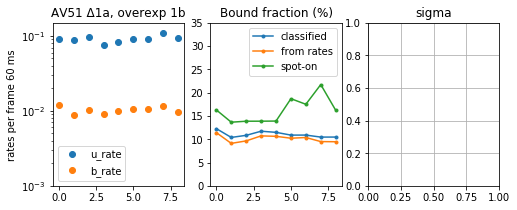

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/


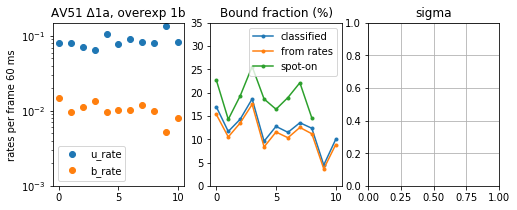

../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/


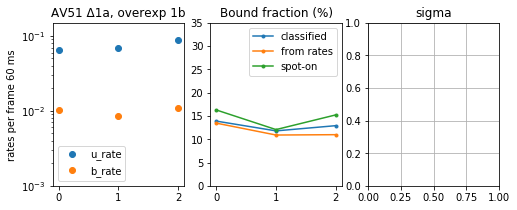

../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/


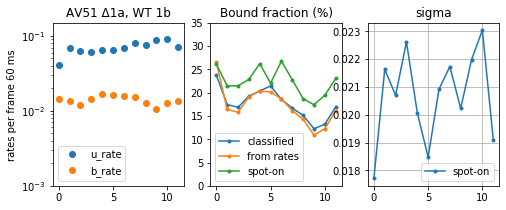

../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/


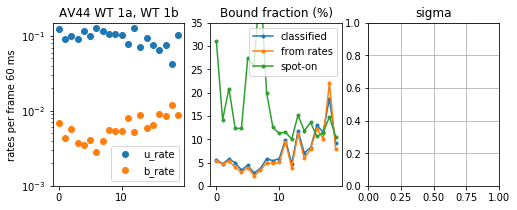

In [171]:
for rate, folder, expression_level, sp in zip(rates, folders, expression_levels_1a_1b, sp_stats):
    print(folder)
    plot_rates_df(rate, sp, expression_level, rates_ylim=(1e-3, .15))
    plt.grid()
    plt.show()

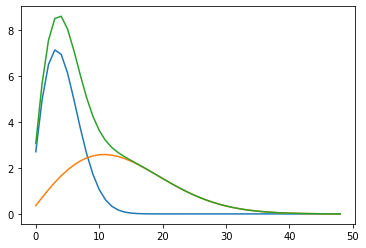

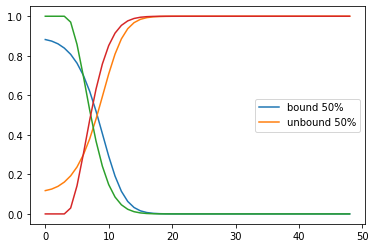

In [97]:
sigma = 0.03
D = 0.1
D0 = 0
dt = 0.06


vector = np.arange(0.01, 0.5, 0.01)

bound = lambda x, f: bayes.p_jd(dt, sigma, D0)(x) * f
diffusive = lambda x, f: bayes.p_jd(dt, sigma, D)(x) * (1 - f)
joint = lambda x, f: f * bayes.p_jd(dt, sigma, D0)(x) + (1 - f) * bayes.p_jd(dt, sigma, D)(x)

bound_norm = lambda x, f: bound(x, f) / joint(x, f)
diffusive_norm = lambda x, f: diffusive(x, f) / joint(x, f)

f=0.5
plt.plot(bound(vector, f))
plt.plot(diffusive(vector, f))
plt.plot(joint(vector, f))

plt.show()


# f1=0.5
# plt.plot(bound_norm(vector, f1), label=f'bound {f1:.0%}')
# plt.plot(diffusive_norm(vector, f1), label=f'unbound {f1:.0%}')

# f2=0.3
# plt.plot(bound_norm(vector, f2), label=f'bound {f2:.0%}')
# plt.plot(diffusive_norm(vector, f2), label=f'unbound {f2:.0%}')

f2=0.5
plt.plot(bound_norm(vector, f2), label=f'bound {f2:.0%}')
plt.plot(diffusive_norm(vector, f2), label=f'unbound {f2:.0%}')

plt.plot([bayes.cdf_bound(sigma, v) for v in vector])
plt.plot([bayes.cdf_unbound(sigma, v) for v in vector])
plt.legend()

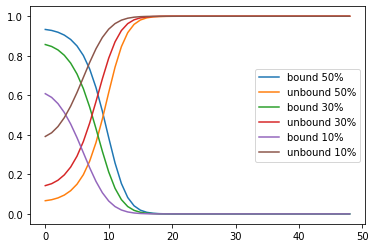

In [86]:
sigma = 0.03
D = 0.2
D0 = 0
dt=0.06


vector = np.arange(0.01, 0.5, 0.01)

bound = lambda x, f: bayes.p_jd(dt, sigma, D0)(x) * f
diffusive = lambda x, f: bayes.p_jd(dt, sigma, D)(x) * (1 - f)
joint = lambda x, f: f * bayes.p_jd(dt, sigma, D0)(x) + (1 - f) * bayes.p_jd(dt, sigma, D)(x)

bound_norm = lambda x, f: bound(x, f) / joint(x, f)
diffusive_norm = lambda x, f: diffusive(x, f) / joint(x, f)

f1=0.5
plt.plot(bound_norm(vector, f1), label=f'bound {f1:.0%}')
plt.plot(diffusive_norm(vector, f1), label=f'unbound {f1:.0%}')

f2=0.3
plt.plot(bound_norm(vector, f2), label=f'bound {f2:.0%}')
plt.plot(diffusive_norm(vector, f2), label=f'unbound {f2:.0%}')

f2=0.1
plt.plot(bound_norm(vector, f2), label=f'bound {f2:.0%}')
plt.plot(diffusive_norm(vector, f2), label=f'unbound {f2:.0%}')

plt.legend()

In [284]:
rates = list(map(get_rates, tqdm(folders)))

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm/_TSrec/MMStack_Pos0_TSlocs.tracked.csv
static : 26008 localizations, 1685 unique tracks
free : 396717 localizations, 68729 unique tracks
min_len: 4
26008 localizations
1685 unique  seg.id
1685  tracks grouped with exp time 60 ms and lengths between 3 and inf
312177 localizations
32204 unique  seg.id
32204  tracks grouped with exp time 60 ms and lengths between 3 and inf
b -> u : 172,          per 24323 bound locs, i.e.             unbinding rate 7.07E-03 per frame
1.1E-01 per second
u -> b : 117,  per 279973 diffusive locs, i.e. binding rate 4.18E-04.
6.3E-03 per second
bound fraction = 5.6%
../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv
static : 18590 localizations, 1142 unique tracks
free : 298631 localizations, 50907 unique tracks
min_len: 4
18590 localizations
1142 unique  seg.id
1142  tracks grouped with e

b -> u : 151,          per 31161 bound locs, i.e.             unbinding rate 4.85E-03 per frame
7.3E-02 per second
u -> b : 110,  per 240203 diffusive locs, i.e. binding rate 4.58E-04.
6.9E-03 per second
bound fraction = 8.6%
../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_4/_TSrec/tracking_60ms_488nm_4_MMStack_Pos0_TSlocs.tracked.csv
static : 38310 localizations, 2432 unique tracks
free : 287469 localizations, 58158 unique tracks
min_len: 4
38310 localizations
2432 unique  seg.id
2432  tracks grouped with exp time 60 ms and lengths between 3 and inf
209302 localizations
24367 unique  seg.id
24367  tracks grouped with exp time 60 ms and lengths between 3 and inf
b -> u : 121,          per 35878 bound locs, i.e.             unbinding rate 3.37E-03 per frame
5.1E-02 per second
u -> b : 58,  per 184935 diffusive locs, i.e. binding rate 3.14E-04.
4.7E-03 per second
bound fraction = 8.5%
../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h1

b -> u : 73,          per 11522 bound locs, i.e.             unbinding rate 6.34E-03 per frame
9.5E-02 per second
u -> b : 96,  per 37210 diffusive locs, i.e. binding rate 2.58E-03.
3.9E-02 per second
bound fraction = 28.9%
../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/tracking_60ms_488nm_10/_TSrec/tracking_60ms_488nm_10_MMStack_Pos0_TSlocs.tracked.csv
static : 20058 localizations, 1200 unique tracks
free : 183905 localizations, 37062 unique tracks
min_len: 4
20058 localizations
1200 unique  seg.id
1200  tracks grouped with exp time 60 ms and lengths between 3 and inf
134050 localizations
15443 unique  seg.id
15443  tracks grouped with exp time 60 ms and lengths between 3 and inf
b -> u : 120,          per 18858 bound locs, i.e.             unbinding rate 6.36E-03 per frame
9.5E-02 per second
u -> b : 83,  per 118607 diffusive locs, i.e. binding rate 7.00E-04.
1.0E-02 per second
bound fraction = 9.9%
../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/tracki

5236  tracks grouped with exp time 60 ms and lengths between 3 and inf
b -> u : 5,          per 1422 bound locs, i.e.             unbinding rate 3.52E-03 per frame
5.3E-02 per second
u -> b : 5,  per 50626 diffusive locs, i.e. binding rate 9.88E-05.
1.5E-03 per second
bound fraction = 2.7%
../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_10/_TSrec/488_tracking_60ms_10_MMStack_Pos0_TSlocs.tracked.csv
static : 3397 localizations, 195 unique tracks
free : 116268 localizations, 17514 unique tracks
min_len: 4
3397 localizations
195 unique  seg.id
195  tracks grouped with exp time 60 ms and lengths between 3 and inf
96404 localizations
9055 unique  seg.id
9055  tracks grouped with exp time 60 ms and lengths between 3 and inf
b -> u : 9,          per 3202 bound locs, i.e.             unbinding rate 2.81E-03 per frame
4.2E-02 per second
u -> b : 10,  per 87349 diffusive locs, i.e. binding rate 1.14E-04.
1.7E-03 per second
bound fraction = 3.9%
../../data/2019/0913-AV44/S1-5.5h

static : 4158 localizations, 257 unique tracks
free : 52319 localizations, 9469 unique tracks
min_len: 4
4158 localizations
257 unique  seg.id
257  tracks grouped with exp time 60 ms and lengths between 3 and inf
40112 localizations
4206 unique  seg.id
4206  tracks grouped with exp time 60 ms and lengths between 3 and inf
b -> u : 18,          per 3901 bound locs, i.e.             unbinding rate 4.61E-03 per frame
6.9E-02 per second
u -> b : 13,  per 35906 diffusive locs, i.e. binding rate 3.62E-04.
5.4E-03 per second
bound fraction = 7.3%
../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_4/_TSrec/488_tracking_60ms_4_MMStack_Pos0_TSlocs.tracked.csv
static : 5029 localizations, 317 unique tracks
free : 131933 localizations, 22492 unique tracks
min_len: 4
5029 localizations
317 unique  seg.id
317  tracks grouped with exp time 60 ms and lengths between 3 and inf
104543 localizations
10643 unique  seg.id
10643  tracks grouped with exp time 60 ms and lengths between 3 and in

In [91]:
rates

[([0.10606808090774543,
   0.08510516361969167,
   0.10250056318990763,
   0.10360759789051197,
   0.10820685778527263,
   0.06690454950936664,
   0.06600176004693457,
   0.07835545722713864,
   0.08615325707174652],
  [0.006268439212212562,
   0.005692919694690825,
   0.0061342027240403945,
   0.008609689339639199,
   0.007375088589652729,
   0.0035764603879917633,
   0.004819562349917138,
   0.0027206935954872764,
   0.004053425955617688]),
 ([0.06206238064926797,
   0.0787516406591804,
   0.07268468005904628,
   0.05058669416650409,
   0.0723114956736712,
   0.0894750080850911,
   0.06899968153993136,
   0.07335515178873717,
   0.037486923166337324,
   0.07621951219512195,
   0.0422260718925942],
  [0.004261951730352403,
   0.005165908001916627,
   0.006869161212968977,
   0.004704330146645326,
   0.0014790666787406802,
   0.005431625640290592,
   0.002206603465184701,
   0.0047439304387827605,
   0.003248682478772498,
   0.0008962447345621844,
   0.0012365949670584842]),
 ([0.09367

In [615]:
def plot_rates(*args):
#     print (args)
    rates, titles = args[0]
    try:
        urates, brates, fb = rates
        plt.semilogy(urates, 'o', label=f'u-rate {titles}')
        plt.semilogy(brates, 'o', label=f'b-rate {titles}')
#         plt.semilogy(fb, 'o', label=f'bound fraction {titles}')
        plt.ylim(5e-4, 1.2e-1)
        plt.legend()
        plt.ylabel('rates per second')
        plt.show()
    except IndexError:
        print(f'bad array shape {r.shape}')
    

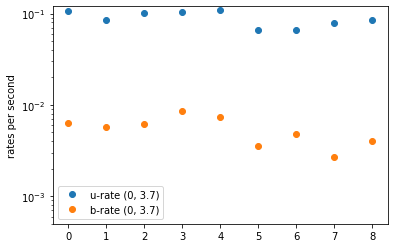

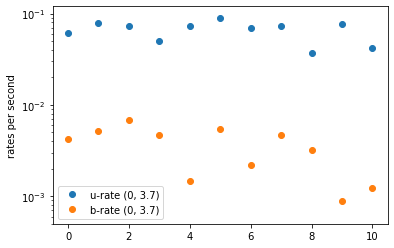

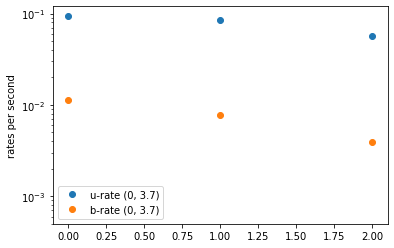

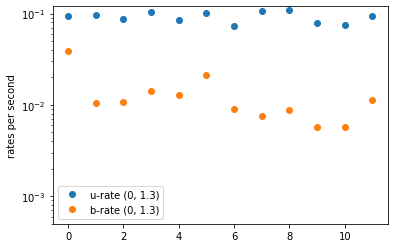

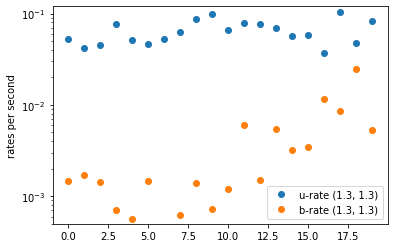

[None, None, None, None, None]

In [616]:
list(map(plot_rates, zip(rates, expression_levels_1a_1b)))

In [1204]:
def plot_track(track: simulate.Track, lim=0.5, jd_lim=0.3, n_lags=3, title=''):

    
    bounds = track[track.prediction == 0]
    if len(bounds):
        blabel = 'preficted bound'
    else:
        bounds = track[track.free == 0]
        blabel = 'true bound'
    fig = plt.figure(figsize=(15, 4))

    fig.add_subplot(131)
    plt.plot(track.x, track.y, '.-', label='trajectory xy')
    plt.plot(track.x[0], track.y[0], 'bo', label='start')
    plt.plot(track.x[-1], track.y[-1], 'go', label='end')
    if len(bounds):
        plt.plot(bounds[:, 0], bounds[:, 1], 'r.', label=blabel)
    plt.xlim(track[:,0].mean() - lim, track[:,0].mean() + lim)
    plt.ylim(track[:,1].mean() - lim, track[:,1].mean() + lim)
    # plt.axis('equal')

    plt.grid()
    plt.legend()
    plt.title(title)


    fig.add_subplot(132)

    jds = [bayes.get_jd(track.xy, lag=l + 1, extrapolate=1) for l in range(n_lags)]
    frames = np.arange(len(jds[0]))
    [plt.plot(track.frame, jd, label=f'jump length {i + 1} Δt', alpha=0.5) for i, jd in enumerate(jds)]
    #     plt.plot(frames[jd_bound_filter], jds[0][jd_bound_filter], 'r.', label='bound')
        
    try:
        jd_unbound_filter = track.prediction == 1
        plt.plot(track.frame, jd_unbound_filter * jd_lim, 'ko-', label='predicted free', alpha=0.5)
    except ValueError:
        print('No prediction, omitting')
        
    try:
#         plt.plot(track.frame, track.col('uncertainty_xy [nm]'), label='sigma')
        plt.plot(track.frame, track.col('uncertainty_xy [nm]') * 3, label='3 * sigma')
    except Exception:
        pass
    
    try:
        swift_id = track.col('seg.id')
        plt.plot(track.frame, (swift_id - min(swift_id)) * jd_lim, label='swift id')
    except Exception:
        pass
    
    
    plt.ylim(-0.01, jd_lim * 1.05)
    plt.legend(loc=(1, 0.5))
    
    fig.add_subplot(133)
    
    
    msd = [np.mean(bayes.get_jd(track.xy, lag=l + 1) ** 2) for l in range(len(track)-2)]
    plt.plot(msd)
    plt.xlabel('frame lag')
    plt.title('MSD')
    
    plt.tight_layout()

In [108]:
t = simulate.track()


In [182]:
t

           x         y     t     sigma  frame  free   id
0   0.002777  0.002570  0.00  0.018666    0.0   0.0  0.0
1  -0.019563  0.012323  0.06  0.018981    1.0   0.0  0.0
2   0.000744 -0.014982  0.12  0.020445    2.0   0.0  0.0
3  -0.014891 -0.020000  0.18  0.023293    3.0   0.0  0.0
4   0.016057 -0.003498  0.24  0.015377    4.0   0.0  0.0
5  -0.008082  0.045104  0.30  0.023637    5.0   0.0  0.0
6  -0.018082 -0.002302  0.36  0.019493    6.0   0.0  0.0
7  -0.023294  0.009972  0.42  0.017219    7.0   0.0  0.0
8  -0.030735 -0.028618  0.48  0.023169    8.0   0.0  0.0
9  -0.008724  0.004173  0.54  0.015610    9.0   0.0  0.0
10  0.034605  0.001004  0.60  0.020096   10.0   0.0  0.0
11  0.008697  0.042364  0.66  0.020061   11.0   0.0  0.0
12 -0.021597 -0.001016  0.72  0.021071   12.0   0.0  0.0
13 -0.003878 -0.027111  0.78  0.018401   13.0   0.0  0.0
14 -0.024602 -0.027733  0.84  0.023972   14.0   0.0  0.0
15 -0.017629 -0.002731  0.90  0.020596   15.0   0.0  0.0
16 -0.035252 -0.020175  0.96  0

In [99]:
t = simulate.track(D_free=0.05, p_binding=1e-10, p_unbinding=1, p_bleaching=1e-5, p_out_of_focus=1e-10, loc_error=2e-2)
plot_track(t)

NameError: name 'plot_track' is not defined

In [302]:
jds = [bayes.get_jd(t.xy, l + 1, extrapolate=1) for  l in range(2)]

[(array([9.9860e+03, 2.2008e+04, 2.0006e+04, 1.1179e+04, 4.3180e+03,
         1.0990e+03, 2.2200e+02, 3.0000e+01, 5.0000e+00, 1.0000e+00]),
  array([3.31374455e-04, 4.66295363e-02, 9.29276982e-02, 1.39225860e-01,
         1.85524022e-01, 2.31822184e-01, 2.78120346e-01, 3.24418507e-01,
         3.70716669e-01, 4.17014831e-01, 4.63312993e-01]),
  <a list of 10 Patch objects>),
 (array([7.4570e+03, 1.7833e+04, 1.8790e+04, 1.3534e+04, 7.1130e+03,
         2.9190e+03, 9.1900e+02, 2.2600e+02, 5.5000e+01, 8.0000e+00]),
  array([4.63146590e-04, 5.44454848e-02, 1.08427823e-01, 1.62410161e-01,
         2.16392499e-01, 2.70374837e-01, 3.24357176e-01, 3.78339514e-01,
         4.32321852e-01, 4.86304190e-01, 5.40286528e-01]),
  <a list of 10 Patch objects>)]

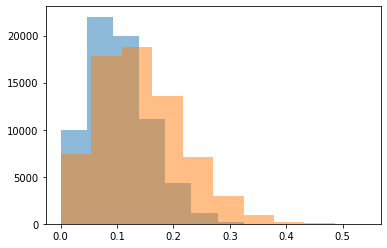

In [303]:
[plt.hist(jd, alpha=0.5) for jd in jds]

In [98]:
lim = 0.3

plt.figure(figsize=(5,5))
plt.hist2d(*jds, bins=30, range=((0, lim), (0, lim)))
plt.axis('equal')
plt.xlim(0, lim)
plt.xlabel('jd1, um')
plt.ylabel('jd2, um')

NameError: name 'jds' is not defined

<Figure size 360x360 with 0 Axes>

In [234]:


sim_params = dict(
    num_tracks = 10000,
    dt = 0.06, 
    D_free=0.1,
    loc_error=0.03, 
    p_binding=0.4e-2, 
    p_unbinding=1.1e-2, 
    p_bleaching=1e-1, 
    p_out_of_focus=1e-2, 
    min_len=5,)

tracks = simulate.tracks(**sim_params)

Simulating 10000 tracks


In [235]:
t = simulate.track(
    dt = 0.06, 
    D_free=0.1,
    loc_error=0.03, 
    p_binding=0.4e-10, 
    p_unbinding=1.1e-1, 
    p_bleaching=1e-1, 
    p_out_of_focus=1e-2, 
    min_len=5,)

In [236]:
t[:, :2] == t.xy

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [237]:
t

          x         y     t     sigma  frame  free   id
0  0.222105  0.090351  0.00  0.029699    0.0   1.0  0.0
1  0.154619 -0.054158  0.06  0.029408    1.0   1.0  0.0
2  0.283661  0.020577  0.12  0.031076    2.0   1.0  0.0
3  0.140219 -0.074501  0.18  0.032566    3.0   1.0  0.0
4  0.060754  0.112877  0.24  0.031827    4.0   1.0  0.0
5  0.142330  0.232654  0.30  0.038241    5.0   1.0  0.0
6  0.308343  0.283610  0.36  0.030650    6.0   1.0  0.0

In [238]:
bayes.classify_bound_segments(t, 0.03)

AttributeError: 'numpy.ndarray' object has no attribute 'xy'

In [239]:
get_switching_rates(tracks, 15)

NameError: name 'get_switching_rates' is not defined

In [6]:
from functools import reduce
lens = [len(t) for t in tracks]

In [7]:
sigmas = reduce(lambda x, y: x + y, [list(t[:,3]) for t in tracks])

In [221]:
jds_total = [reduce(lambda x, y: x + y, [list(bayes.get_jd(t, lag)) for t in tqdm(tracks[:])]) for lag in tqdm(range(1,8))]

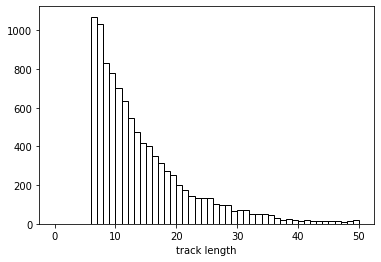

In [9]:
_ = plt.hist(lens, bins=50, range=(0,50), fill=None)
plt.xlabel('track length')
plt.show()

Text(0.5, 0, 'sigma, um')

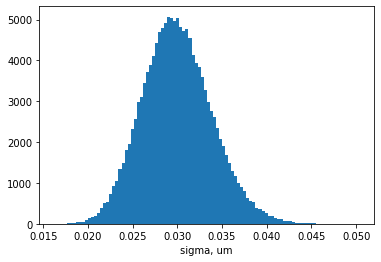

In [11]:
_ = plt.hist(sigmas, bins=100)
plt.xlabel('sigma, um')

In [222]:
dt = sim_params['dt']
sigma = sim_params['loc_error']
D_free = sim_params['D_free']
F_bound = sim_params['p_binding'] / ( sim_params['p_binding'] +  sim_params['p_unbinding'])

def plot_jds(jds, max_um=.6, bins=100):
    n = len(jds)
    xrange = np.arange(0, max_um, 0.01)
    fig = plt.figure(figsize=(10,n * 1.2))
    for i, j in enumerate(jds[:]):
        fig.add_subplot(n, 1, i + 1)
        _ = plt.hist(j, bins=bins, range=(0, max_um), density=True, label=f'{i+1}Δt', fill=None)
        plt.plot(xrange, F_bound * bayes.p_jd((i + 1) * dt, sigma, 0)(xrange), label='bound')
        plt.plot(xrange, (1 - F_bound) * bayes.p_jd((i + 1) * dt, sigma, D_free)(xrange), label='unbound')
        plt.plot(xrange, F_bound * bayes.p_jd((i + 1) * dt, sigma, 0)(xrange) + (1 - F_bound) * bayes.p_jd((i + 1) * dt, sigma, D_free)(xrange))
        plt.legend()
    plt.xlabel('jump length, um')
    plt.tight_layout()
    return fig

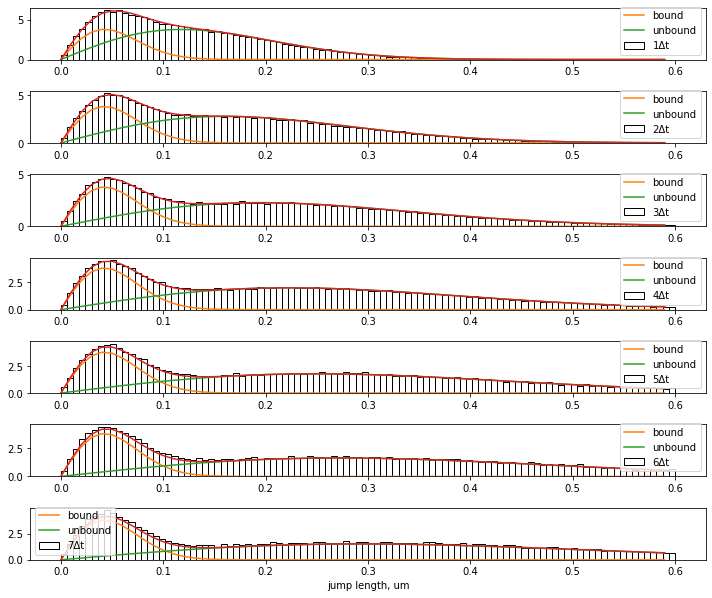

In [223]:
_ = plot_jds(jds_total)


In [19]:
mobile_tracks = list(filter(lambda t: np.mean(t[:,-1]) == 0, tracks))
len(mobile_tracks)

1

In [20]:
bound_tracks = list(filter(lambda t: np.mean(t[:,-1]) == 1, tracks))
len(bound_tracks)

1

In [21]:
switching_tracks = list(filter(lambda t: np.mean(t[:,-1]) > 0 and np.mean(t[:,-1]) < 1, tracks))
len(switching_tracks)

0

In [22]:
def segment_bound_unbound(track_xy, track_sigma, sigma_mul=3, sigma_tolerance=0.6, lags = range(2,7,2), verbose=False, true_bound=None):
    assert track_xy.shape[0] > 4
    assert track_xy.shape[1] == 2
    if isinstance(track_sigma, np.ndarray):
        assert track_sigma.ndim == 1
        assert len(track_sigma) == len(track_xy)
    elif isinstance(track_sigma, (int, float)):
        assert sigma > 0
    
    jds = [get_jd(track_xy, lag, extrapolate=True) for lag in lags]
    jds = list(filter(lambda a: len(a) > 0, jds))
    # print(jds)
    mean_jds = np.mean(jds, axis=0)
    bound = mean_jds < sigma_mul * track_sigma
    
    if not verbose: return bound
    
    fig = plt.figure(figsize=(15,4))

    fig.add_subplot(131)
    [plt.plot(t[:,0], t[:,1], '.-') for t in [track]]
    [plt.plot(t[:,0], t[:,1], 'r.') for t in [track[track[:,-1] == 1]]]
    plt.plot(track[0,0], track[0,1], 'bo')
    plt.grid()
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.axis('equal')
    # plt.show()

    fig.add_subplot(132)

    [plt.plot(jd, label=f'{lag}Δt', alpha=0.5) for jd, lag in zip(jds, lags)]
    plt.plot(range(len(track)), sigma_mul * track_sigma , '--', label=f'{sigma_mul} sigma')
#     plt.plot(range(len(track)), sigma_tolerance * sigma_mul * track[:, 3], '--', label=f'{sigma_tolerance * sigma_mul:.1f} sigma')
    plt.plot(mean_jds, '-.', label=f'mean jd')
    if true_bound is not None:
        plt.plot(true_bound, 'ro', label='true bound')
#     plt.plot(np.logical_or(mean_jds < sigma_mul * sigmas, np.logical_not(mean_jds > sigma_tolerance * sigma_mul * sigmas)), 'ko', label='bound')
    plt.plot(bound, 'ko', label='bound')
    plt.legend()
    plt.grid()
    # plt.show()

    fig.add_subplot(133)
    _ = plt.hist(jds, stacked=1, range=(0, 0.3))
    plt.show()
    
    return bound

In [21]:
lim = 0.5
index = np.random.randint(len(switching_tracks))
print(index)
track = switching_tracks[index]

bound = segment_bound_unbound(track[:, :2], track_sigma=track[:, 3], sigma_mul=4, verbose=1, true_bound=track[:, -1])

def count_false_negative_false_positive(vector, truth):
    diff = vector - truth
#     print(diff)
    n_fn = sum(diff == -1.)
    n_fp = sum(diff == 1.)
    return n_fn, n_fp, truth.mean(), len(truth)

def segment_with_truth(track, sigma_mul=4):
    bound = segment_bound_unbound(track[:, :2], track_sigma=track[:, 3], sigma_mul=sigma_mul, verbose=0)
    return bound



ValueError: Range cannot be empty (low >= high) unless no samples are taken

0.011252829421211523
0.9887471705787885


Text(0.5, 1.0, 'sigma: 0.02, D: 0.06')

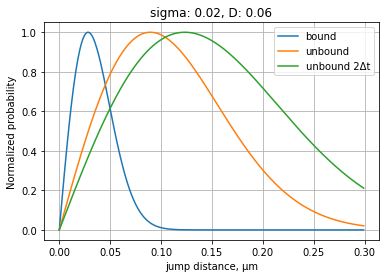

In [947]:
sigma = 0.02
r = 0.1
x = np.arange(0., .3, 0.001)
dt=0.06
D=0.06
alpha = 1

print(bayes.cdf_bound(sigma, r) )
print(bayes.cdf_unbound(sigma, r) )
plt.plot(x, [bayes.p_jd_norm(1, sigma, 0)(r) for r in x], alpha=alpha, label='bound')
plt.plot(x, [bayes.p_jd_norm(dt, sigma, D)(r) for r in x], alpha=alpha, label='unbound')
plt.plot(x, [bayes.p_jd_norm(2 * dt, sigma, D)(r) for r in x], alpha=alpha, label='unbound 2Δt')
# plt.plot(x, [bayes.cdf_bound(sigma, r) for r in x], label='cdf_bound')
# plt.plot(x, [bayes.cdf_unbound(sigma, r) for r in x], label='cdf_unbound')
plt.legend()
plt.grid()
plt.xlabel('jump distance, μm')
plt.ylabel('Normalized probability')
plt.title(f'sigma: {sigma}, D: {D}')

In [24]:
def jd_weighted_average(track, dt, sigma, D, max_lag=4):
    lags = range(1, max_lag + 1)
    jds = np.array([get_jd(track[:, :2], lag=lag, extrapolate=1) for lag in lags])
    weights = np.array([p_jd_norm(lag * dt, sigma, D)(jd) for lag, jd in zip(lags, jds)])
    lags_ = np.array(lags).reshape((len(lags), 1))
    diffusions = (jds ** 2 - sigma ** 2) / lags_
    D_per_timepoint = np.average(diffusions, axis=0, weights=weights)
    
#     jds_weighted = jds * weights
#     jds_weighted_sq = jds_weighted ** 2
    return D_per_timepoint
    

In [15]:
D=0.06
dt=0.06
sigma=0.02

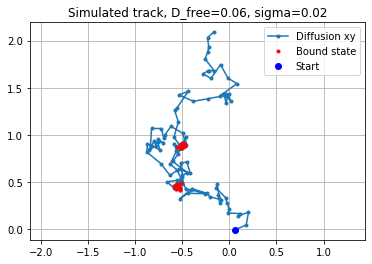

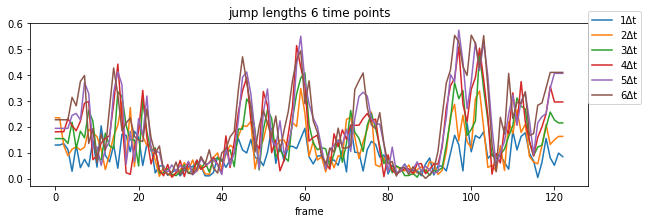

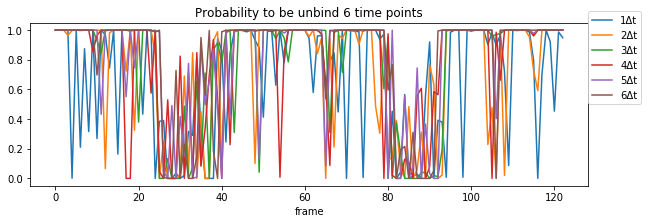

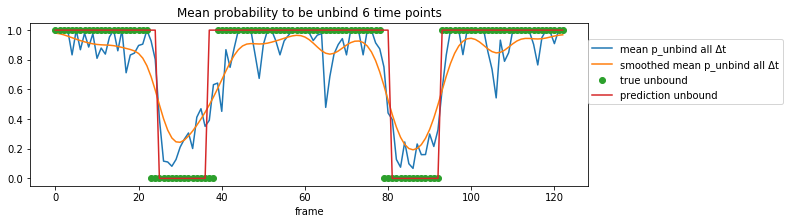

In [63]:


# track = simulate.track(
#     dt=dt,
#     D_free=D,
#     loc_error=sigma,
#     p_binding=0.02,
#     p_unbinding=0.11,
#     p_bleaching=0.02,
#     p_out_of_focus=0.0001,
#     min_len=6,)

# track_ = simulate.Track(track)
# print(track)


max_lag = 6
# print(track)

track_with_state, p_unbinds = bayes.classify_bound_segments(track, sigma, max_lag, return_p_unbinds=True)
# print(track_with_state)

jds = [bayes.get_jd(track.xy, lag=l + 1, extrapolate=1) for l in range(max_lag)]

jds = list(filter(len, jds))

lim = 1.
plt.title(f'Simulated track, D_free={D}, sigma={sigma}')
plt.plot(track.x, track.y, '.-', label='Diffusion xy') 

b_indices = np.ravel(track[track.free == 0])
if len(track[track.free == 0]) > 0:
    bound_spots = simulate.Track(track[track.free == 0], columns=track.columns, units=track.units)
#     print(bound_spots)

    plt.plot(bound_spots.x, bound_spots.y, 'r.', label='Bound state')
plt.plot(track.x[0], track.y[0], 'bo', label='Start')
plt.legend()
plt.grid()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.axis('equal')
plt.show()

plt.figure(figsize=(10,3))
plt.title(f'jump lengths {max_lag} time points')
[plt.plot(jd, label=f'{i + 1}Δt') for i, jd in enumerate(jds)]
# plt.plot(track.free, 'o', alpha=1, label='true unbound')
# plt.plot(track_with_state.prediction, '-', label='prediction unbound')
# plt.plot()
plt.xlabel('frame')
plt.legend(loc=(1, 0.5))

plt.figure(figsize=(10,3))
plt.title(f'Probability to be unbind {max_lag} time points')
[plt.plot(pu, label=f'{i + 1}Δt') for i, pu in enumerate(p_unbinds)]
# plt.plot(track.free, 'o', alpha=1, label='true unbound')
# plt.plot(track_with_state.prediction, '-', label='prediction unbound')
plt.xlabel('frame')
plt.legend(loc=(1, 0.5))

plt.figure(figsize=(10,3))
plt.title(f'Mean probability to be unbind {max_lag} time points')
plt.plot(np.mean(p_unbinds, axis=0), label=f'mean p_unbind all Δt')
plt.plot(gf1(np.mean(p_unbinds, axis=0), 3), label=f'smoothed mean p_unbind all Δt')
plt.plot(track.free, 'o', alpha=1, label='true unbound')
plt.plot(track_with_state.prediction, '-', label='prediction unbound')
plt.xlabel('frame')

plt.legend(loc=(1, 0.5))

plt.ylim(-0.05, 1.05)
# plt.legend(loc=(1, 0.5))
plt.show()

In [242]:
def select_populations(xytfu, col='free'):
    '''
    Returns
    bound, unbound, switching tracks
    '''
    state = lambda t: t.col(col)
    bound = list(filter(lambda t: np.mean(state(t)) == 0, xytfu))
    unbound = list(filter(lambda t: np.mean(state(t)) == 1, xytfu))
    switching = list(filter(lambda t: 0 < np.mean(state(t)) < 1, xytfu))

    print(f'bound {len(bound)} / {len(xytfu)} tracks')
    print(f'unbound {len(unbound)} / {len(xytfu)} tracks')
    print(f'switching {len(switching)} / {len(xytfu)} tracks')
    return bound, unbound, switching

In [314]:
xml = glob('../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm/*Tracks.xml')
xml

['../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm/MMStack_Pos0.ome.tif.Tracks.xml']

In [1102]:
xml = glob('../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/tracking_60ms_488nm_1/*Tracks.xml')
xml

['../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/tracking_60ms_488nm_1/tracking_60ms_488nm_1_MMStack_Pos0.ome.tif.Tracks.xml']

In [315]:
csv = glob('../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm/_TSrec/*.tracked.csv')
csv

['../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm/_TSrec/MMStack_Pos0_TSlocs.tracked.csv']

In [1097]:
csv = glob('../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/tracking_60ms_488nm_1/_TSrec/*.tracked.csv')
csv

['../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv']

In [1158]:
df.columns

Index(['frame', 'x [nm]', 'y [nm]', 'sigma [nm]', 'intensity [photon]',
       'offset [photon]', 'bkgstd [photon]', 'chi2', 'uncertainty_xy [nm]',
       'jd', 'dt', 'id', 'seg_pos', 'track_pos', 'seg.mjd', 'seg.mjd_std_err',
       'seg.mjd_n', 'seg.dynamics', 'seg.t_start', 'seg.lifetime', 'seg.id',
       'seg.loc_count', 'seg.track_pos', 'track.noise', 'track.t_start',
       'track.lifetime', 'track.id', 'track.loc_count', 'track.seg_count'],
      dtype='object')

In [1166]:
tracks_with_sigma = swift.group_tracks_swift(
            df, 
            additional_columns=['seg.id', 'uncertainty_xy [nm]'],
            additional_scale=[1, 0.001],
            additional_units=[int, 'um'],
            group_by='track.id',
            min_len=5,
            max_len=50
            )
tracks_with_sigma[0].col('uncertainty_xy [nm]')

84630 localizations
29008 unique  track.id
4005  tracks grouped with exp time 60 ms and lengths between 5 and 50


array([0.01630462, 0.01164378, 0.01242822, 0.01109418, 0.01150629,
       0.01345649, 0.01596085])

In [1168]:
tracks_with_sigma[0]

           x          y  time  frame  track.id  seg.id  uncertainty_xy [nm]
0  52.860811  35.841752  0.06    1.0       0.0     0.0             0.016305
1  52.890569  35.879518  0.12    2.0       0.0     0.0             0.011644
2  52.877972  35.863288  0.18    3.0       0.0     0.0             0.012428
3  52.894184  35.864992  0.24    4.0       0.0     0.0             0.011094
4  52.875599  35.854779  0.30    5.0       0.0     0.0             0.011506
5  52.913770  35.846573  0.36    6.0       0.0     0.0             0.013456
6  52.884907  35.860131  0.42    7.0       0.0     0.0             0.015961

In [1103]:
exp_tracks = readers.read_trackmate_xml(xml[0])

In [1105]:
fit_params = timecourse.fit_params

In [1106]:
fit_params

{'states': 2,
 'iterations': 1,
 'CDF': False,
 'CDF1': True,
 'Frac_Bound': [0, 1],
 'D_Free': [0.02, 0.2],
 'D_Med': [0.005, 0.5],
 'D_Bound': [0.0, 0.005],
 'sigma': 0.025,
 'sigma_bound': [0.005, 0.1],
 'fit_sigma': True,
 'dT': 0.06,
 'useZcorr': False,
 'plot_hist': False,
 'plot_result': True}

In [1107]:
sp_fit = timecourse.process_xml_with_automatic_fps(xml[0], fit_params, )

../../data/2019/0910-AV51-diff-dCas9/S2-10-18-WT-OD_0.13-10h25/tracking_60ms_488nm_1/tracking_60ms_488nm_1_MMStack_Pos0.ome.tif.Tracks.xml
Found previous fit, recovering stats


In [1108]:
sp_fit

,D_free,D_bound,F_bound,sigma,chi2,num_tracks,time_stamp
tracking_60ms_488nm_1_MMStack_Pos0.ome.tif.Tracks.xml,0.053423,0.000023,0.261251,0.017715,0.005363,2344,1.568105e+09


In [325]:
exp_tracks_10 = list(filter(lambda x: len(x) > 10, exp_tracks))

Text(0.5, 0, 'track length')

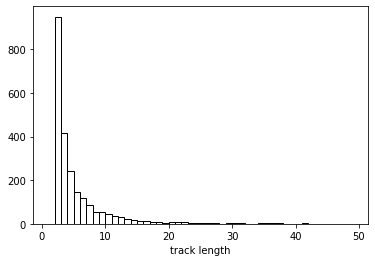

In [1155]:
plt.hist([len(x) for x in exp_tracks], bins =range(1, 50), fill=None)
plt.xlabel("track length")

In [1113]:
classify_tracks = lambda tracks, max_lag: \
    list(map(lambda t: \
             bayes.classify_bound_segments(
                t, 
                sigma=t.sigma.mean(), 
                max_lag=max_lag, 
                extrapolate_edges=False
            ), 
            tqdm(tracks)
        )
    )

In [1175]:
c_csv_tracks = [{'lag': lag, 'classified tracks': classify_csv_tracks(tracks_with_sigma[:], lag)} for lag in [4]]

In [1170]:
track = c_csv_tracks[0]['classified tracks'][0]

In [1171]:
track

           x          y  time  frame  track.id  seg.id  uncertainty_xy [nm]  \
0  52.860811  35.841752  0.06    1.0       0.0     0.0             0.016305   
1  52.890569  35.879518  0.12    2.0       0.0     0.0             0.011644   
2  52.877972  35.863288  0.18    3.0       0.0     0.0             0.012428   
3  52.894184  35.864992  0.24    4.0       0.0     0.0             0.011094   
4  52.875599  35.854779  0.30    5.0       0.0     0.0             0.011506   
5  52.913770  35.846573  0.36    6.0       0.0     0.0             0.013456   
6  52.884907  35.860131  0.42    7.0       0.0     0.0             0.015961   

   prediction  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  

In [1172]:
track.col('prediction')

array([0., 0., 0., 0., 0., 0., 0.])

In [1173]:
for c in c_tracks:
    tracks = c['classified tracks']
    lag = c['lag']
    print(f'max_lag {lag}')
    stats = get_switching_rates(tracks, 15, column='prediction')
    c['stats'] = stats

max_lag 4
14648 13959
bound fraction based on number of spots: 14648 / 45312 = 32.3%
615 binding events, 551 unbinding events
Unbinding switching rates: 3.9% per frame, 59.2% per second 15 fps
Binding switching rates: 2.1% per frame, 32.0% per second 15 fps
Bound fraction based on switching rates: 35.1%
max_lag 6
12441 11866
bound fraction based on number of spots: 12441 / 45312 = 27.5%
280 binding events, 215 unbinding events
Unbinding switching rates: 1.8% per frame, 27.2% per second 15 fps
Binding switching rates: 0.9% per frame, 13.6% per second 15 fps
Bound fraction based on switching rates: 33.3%
max_lag 8
11597 11069
bound fraction based on number of spots: 11597 / 45312 = 25.6%
179 binding events, 125 unbinding events
Unbinding switching rates: 1.1% per frame, 16.9% per second 15 fps
Binding switching rates: 0.6% per frame, 8.5% per second 15 fps
Bound fraction based on switching rates: 33.3%


In [1176]:
for c in c_csv_tracks:
    tracks = c['classified tracks']
    lag = c['lag']
    print(f'max_lag {lag}')
    stats = get_switching_rates(tracks, 15, column='prediction')
    c['stats'] = stats

max_lag 4
10881 10099
bound fraction based on number of spots: 10881 / 45862 = 23.7%
464 binding events, 409 unbinding events
Unbinding switching rates: 4.0% per frame, 60.7% per second 15 fps
Binding switching rates: 1.5% per frame, 21.9% per second 15 fps
Bound fraction based on switching rates: 26.5%


In [1177]:
for c in c_csv_tracks:
    tracks = c['classified tracks']
    lag = c['lag']
    print(f'max_lag {lag}')
    stats = bayes.get_switching_rates(tracks, fps=15, lag=4, column='prediction')
    c['stats'] = stats

max_lag 4
Due to lag=4, 3291 tracks left out of 4005 with len > 5
bound fraction based on number of spots: 7765 / 29128 = 26.7%
327 binding events, 279 unbinding events
Unbinding switching rates: 3.9% per frame, 58.8% per second 15 fps
Binding switching rates: 1.7% per frame, 26.2% per second 15 fps
Bound fraction based on switching rates: 30.8%


In [1293]:
def show_switching_tracks(c_csv_tracks):
    for c in c_csv_tracks:
        tracks = c['classified tracks']
        for i, t in list(enumerate(tracks[:])):
            if np.mean(t.prediction) < 1 and len(t) > 9:
                title = int(t.col("track.id")[0])
                yield plot_track(t, title=f'track.id #{title}')

In [1294]:
s = iter(show_switching_tracks(c_csv_tracks))

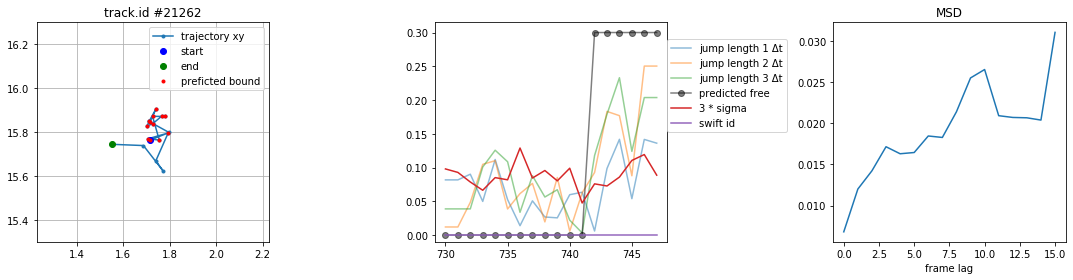

In [1708]:
next(s)

In [1095]:
def show_MSD_tracks(c_csv_tracks):
    for c in c_csv_tracks:
        tracks = c['classified tracks']
        num = 0
        for i, t in list(enumerate(tracks[10000:])):
            if 0.1 < np.mean(t.prediction) < 0.9:
#                 print(f'track #{i + 8000}')
                msd = np.array([np.mean(bayes.get_jd(t.xy, lag=l + 1) ** 2) for l in range(len(t)-2)])
#                 print(msd - msd[0] + 0.01)
                plt.plot(np.arange(len(msd)) + 1, msd, alpha=0.2)
                num += 1
        plt.xlabel('frame lag')
        plt.title(f'MSD {num} tracks')

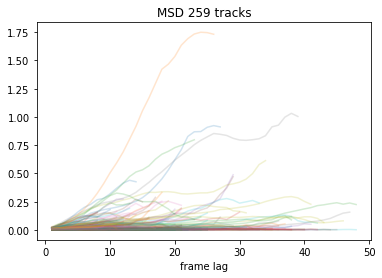

In [1096]:
show_MSD_tracks(c_csv_tracks)

In [339]:
sp_fit

,D_free,D_bound,F_bound,sigma,chi2,num_tracks,time_stamp
MMStack_Pos0.ome.tif.Tracks.xml,0.05417,0.001028,0.162865,0.023674,0.002336,24108,1.568035e+09


In [348]:
sim_params = {
    'num_tracks': sp_fit.num_tracks.values[0],
 'dt': 0.06,
 'D_free': sp_fit.D_free.values[0],
 'loc_error': sp_fit.sigma.values[0],
 'p_binding': c_csv_tracks[0]['stats']['b_rate_frame'],
 'p_unbinding': c_csv_tracks[0]['stats']['u_rate_frame'],
 'p_bleaching': 0.1,
 'p_out_of_focus': 0.01,
 'min_len': 10}
# sim_tracks = 

In [349]:
sim_params

{'num_tracks': 24108,
 'dt': 0.06,
 'D_free': 0.054170454900000005,
 'loc_error': 0.0236736983,
 'p_binding': 0.007584974415991897,
 'p_unbinding': 0.05685329378321592,
 'p_bleaching': 0.1,
 'p_out_of_focus': 0.01,
 'min_len': 10}

In [350]:
sim_tracks = simulate.tracks(**sim_params)

Simulating 24108 tracks


In [368]:
c_sim_tracks = classify_tracks(sim_tracks, max_lag=4)

In [344]:
c_sim_tracks[0].col('free')

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [234]:
def get_switching_error(classified_track:simulate.Track, cols=['free', 'prediction']):
    a = classified_track.col(cols[0])
    b = classified_track.col(cols[1])
    
    err = b - a
    
    sw_err =err[1:] - err[:-1]
    
    good = sum(sw_err == 0)
    false_positive = sum(sw_err == 1)
    false_negative = sum(sw_err == -1)
    
    return false_negative, good, false_positive

In [235]:
def get_prediction_error(classified_track:simulate.Track, cols=['free', 'prediction']):
    a = classified_track.col(cols[0])
    b = classified_track.col(cols[1])
     
    err = b - a
    
    good = sum(err == 0)
    false_positive = sum(err == 1)
    false_negative = sum(err == -1)
    
    return false_negative, good, false_positive

In [236]:
get_prediction_error(c_sim_tracks[0])

(0, 17, 0)

In [237]:
get_switching_error(c_sim_tracks[0])

(0, 16, 0)

In [238]:
err = list(map(get_prediction_error, c_sim_tracks))

neg, good, pos = np.sum(err, axis=0)

print(f'false negative {neg/good:.1%}, false positive {pos/good:.1%}')

false negative 0.4%, false positive 1.1%


In [239]:
err = list(map(get_switching_error, c_sim_tracks))

neg, good, pos = np.sum(err, axis=0)

print(f'false negative {neg/good:.1%}, false positive {pos/good:.1%}')

false negative 0.6%, false positive 0.6%


In [353]:
sim_tracks[2]

           x         y     t     sigma  frame  free   id
0  -0.144004  0.091050  2.00  0.029257    0.0   1.0  2.0
1  -0.252036  0.167522  2.06  0.023056    1.0   1.0  2.0
2  -0.242426  0.176163  2.12  0.020659    2.0   0.0  2.0
3  -0.233027  0.220023  2.18  0.027056    3.0   0.0  2.0
4  -0.255342  0.215423  2.24  0.025116    4.0   0.0  2.0
5  -0.264510  0.221660  2.30  0.029941    5.0   0.0  2.0
6  -0.319358  0.153711  2.36  0.025492    6.0   0.0  2.0
7  -0.233133  0.220425  2.42  0.021586    7.0   0.0  2.0
8  -0.273458  0.188084  2.48  0.028043    8.0   0.0  2.0
9  -0.244727  0.194610  2.54  0.022661    9.0   0.0  2.0
10 -0.250301  0.163322  2.60  0.026566   10.0   0.0  2.0

In [358]:
get_switching_rates(sim_tracks[:3], 15, column='free')


9 8
bound fraction based on number of spots: 9 / 68 = 13.2%
1 binding events, 0 unbinding events
Unbinding switching rates: 0.0% per frame, 0.0% per second 15 fps
Binding switching rates: 1.8% per frame, 26.3% per second 15 fps
Bound fraction based on switching rates: 100.0%


{'F_bound': 0.1323529411764706,
 'u_rate_frame': 0.0,
 'b_rate_frame': 0.017543859649122806}

In [374]:
print('sim params: ', sim_params)
print(f"simulated u-rate: {sim_params['p_unbinding']:.1%} per frame")
print(f"simulated b-rate: {sim_params['p_binding']:.1%} per frame")

print(f"expected F_bound: {sim_params['p_binding'] / (sim_params['p_binding'] + sim_params['p_unbinding']) :.1%}")

print('\ntrue states')
bayes.get_switching_rates(sim_tracks, 15, column='free')

for data in [[c_sim_tracks, 4]]:
    
    print(f'\npredicted states lag {data[1]}')
    bayes.get_switching_rates(data[0], 15, column='prediction')
    


sim params:  {'num_tracks': 24108, 'dt': 0.06, 'D_free': 0.054170454900000005, 'loc_error': 0.0236736983, 'p_binding': 0.007584974415991897, 'p_unbinding': 0.05685329378321592, 'p_bleaching': 0.1, 'p_out_of_focus': 0.01, 'min_len': 10}
simulated u-rate: 5.7% per frame
simulated b-rate: 0.8% per frame
expected F_bound: 11.8%

true states
Due to lag=4, 24108 tracks left out of 24108 with len > 5
bound fraction based on number of spots: 44545 / 368343 = 12.1%
2239 binding events, 2395 unbinding events
Unbinding switching rates: 5.7% per frame, 85.8% per second 15 fps
Binding switching rates: 0.7% per frame, 11.1% per second 15 fps
Bound fraction based on switching rates: 11.5%

predicted states lag 4
Due to lag=4, 24108 tracks left out of 24108 with len > 5
bound fraction based on number of spots: 41408 / 368343 = 11.2%
2224 binding events, 2402 unbinding events
Unbinding switching rates: 6.2% per frame, 92.9% per second 15 fps
Binding switching rates: 0.7% per frame, 10.9% per second 15 

track number 4970


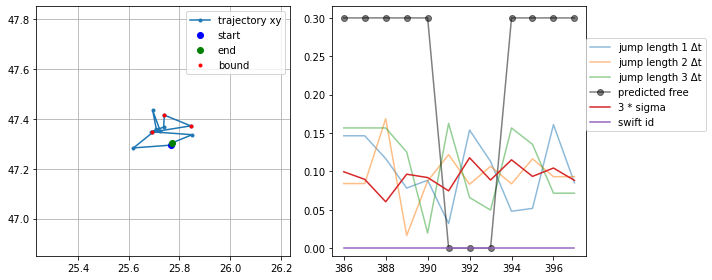

In [938]:
tracks = c_csv_tracks[0]['classified tracks']
i = np.random.randint(len(tracks))
track = tracks[i]

print(f'track number {i}')
plot_track(track)

In [818]:
track

            x          y   time  frame   seg.id  uncertainty_xy [nm]  \
0   35.506905  19.885536  10.02  167.0  35029.0             0.042851   
1   35.404451  19.773391  10.08  168.0  35029.0             0.030702   
2   35.450602  19.821702  10.14  169.0  35029.0             0.029383   
3   35.403368  19.861546  10.32  172.0  35029.0             0.031092   
4   35.467679  19.776868  10.38  173.0  35029.0             0.035445   
5   35.506313  19.742857  10.44  174.0  35029.0             0.023670   
6   35.448272  19.665816  10.50  175.0  35029.0             0.038726   
7   35.519119  19.635007  10.56  176.0  35029.0             0.018348   
8   35.599668  19.587653  10.62  177.0  35029.0             0.020527   
9   35.748297  19.419324  10.68  178.0  35029.0             0.022986   
10  35.775569  19.421277  10.74  179.0  35029.0             0.034617   
11  35.602640  19.395284  10.86  181.0  35029.0             0.025709   
12  35.490154  19.267141  10.92  182.0  35029.0             0.02

In [940]:
swift_tracks = pd.read_csv(csv[0])


In [944]:
swift_tracks[swift_tracks['seg.id'] == 35029]['seg.dynamics']

108677    free
109266    free
109860    free
111686    free
112247    free
112824    free
113392    free
113930    free
114483    free
115036    free
115608    free
116755    free
117330    free
118434    free
118979    free
119526    free
120081    free
Name: seg.dynamics, dtype: object

In [945]:
swift.select_populations(swift_tracks)

static : 26008 localizations, 1685 unique tracks
free : 396717 localizations, 68729 unique tracks
min_len: 4


{'static':         frame       x [nm]       y [nm]  sigma [nm]  intensity [photon]  \
 444         4  14809.60368  36973.46107   167.96971          1446.32032   
 498         4  24575.14760  11987.10054   134.36353           739.24044   
 645         4  45202.54389  11105.63845   129.59656           793.28976   
 733         4  58190.84528  10419.47019   121.73033           387.35807   
 870         5  14796.50222  36948.33394   120.71322           646.73654   
 ...       ...          ...          ...         ...                 ...   
 539001    998  32768.46798   5982.43416   216.85600           753.16714   
 539123    998  47776.55573  57180.47543   120.68413           267.76511   
 539126    998  48261.71490   4338.93819   129.40564           338.08937   
 539186    998  55372.55792   9239.56551   120.45942           887.65180   
 539233    998  60336.90618  57874.37574   111.98732           205.61585   
 
         offset [photon]  bkgstd [photon]         chi2  uncertainty_xy [nm] 

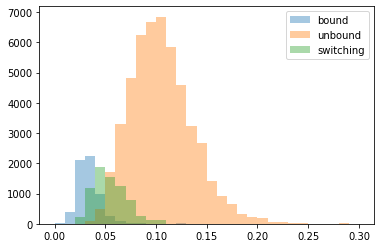

In [549]:
for pops, label in zip([bound, unbound, switching], ['bound', 'unbound', 'switching']):
    jds = np.array(list(map(lambda t: (bayes.get_jd(t[:,:2]).mean(), len(t)-1), pops)))
    plt.hist(jds[:, 0], weights=jds[:, 1], alpha=0.4, bins=30, range=(0, 0.3), label=label)
plt.legend()

In [2735]:
sim_params = dict(
    num_tracks = 10000,
    dt = dt, 
    D_free=D,
    loc_error=sigma, 
    p_binding=1.5e-3, 
    p_unbinding=7e-3, 
    p_bleaching=1e-1, 
    p_out_of_focus=1e-2, 
    min_len=5,
    max_len=50)

tracks = simulate_tracks(**sim_params)

bounds = list(map(lambda t: segment_bound_unbound(t[:, :2], t[:,3], sigma_mul=4), tqdm(tracks)))

fn_fp_bound_len = np.array(list(map(lambda args: count_false_negative_false_positive(args[0], args[1][:,4]), zip(bounds, tracks[:]))))

total_fn = fn_fp_bound_len[:, 0].sum() / fn_fp_bound_len[:, 3].sum()
total_fp = fn_fp_bound_len[:, 1].sum() / fn_fp_bound_len[:, 3].sum()
print(f'False negative: {total_fn:.1%}, false positive: {total_fp:.1%}')

Simulating 10000 tracks


False negative: 0.2%, false positive: 11.5%


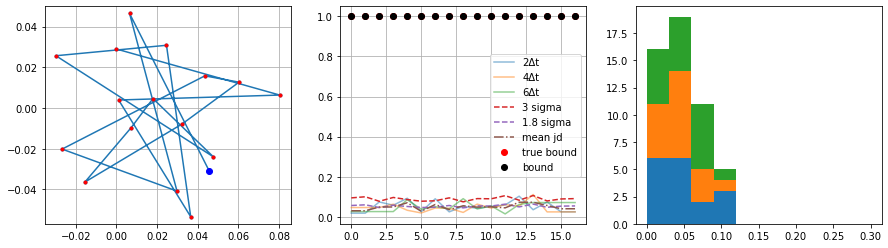

In [869]:
lim = 0.5
track = bound_tracks[np.random.randint(len(bound_tracks))]

segment_bound_unbound(track, )

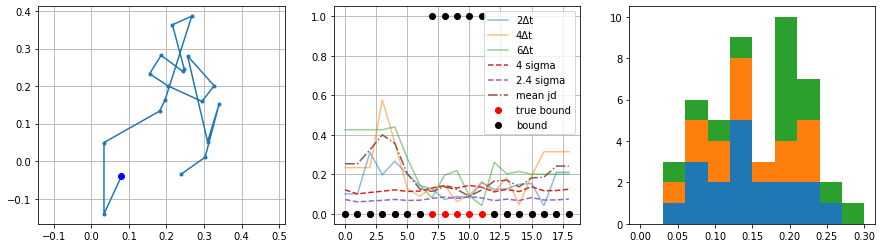

In [886]:
lim = 0.5
track = mobile_tracks[np.random.randint(len(mobile_tracks))]

segment_bound_unbound(track, sigma_mul=4)

In [150]:
data = glob('../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/*/_TSrec/*.tracked.csv')

In [7]:
data

['../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm/_TSrec/MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_2/_TSrec/tracking_60ms_488nm_2_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_3/_TSrec/tracking_60ms_488nm_3_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_4/_TSrec/tracking_60ms_488nm_4_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_5/_TSrec/tracking_60ms_488nm_5_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_6/_TSrec/tracking_60ms_488nm_6_MMStack_Pos0_TSlocs.tr

In [8]:
p = lambda path: swift.process_switching_rate(path, frame_rate=15)
rates = list(map(p, data))

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm/_TSrec/MMStack_Pos0_TSlocs.tracked.csv
static : 26008 localizations, 1685 unique tracks
free : 396717 localizations, 68729 unique tracks
min_len: 4
26008 localizations
1685 unique  seg.id
1684  tracks grouped with exp time 60 ms and lengths between 3 and inf
312177 localizations
32204 unique  seg.id
32203  tracks grouped with exp time 60 ms and lengths between 3 and inf
b -> u : 172,          per 24324 bound locs, i.e.             unbinding rate 7.07E-03 per frame
1.1E-01 per second
u -> b : 117,  per 279974 diffusive locs, i.e. binding rate 4.18E-04.
6.3E-03 per second
bound fraction = 5.6%
../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv
static : 18590 localizations, 1142 unique tracks
free : 298631 localizations, 50907 unique tracks
min_len: 4
18590 localizations
1142 unique  seg.id
1141  tracks grouped with e

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm/_TSrec/MMStack_Pos0_TSlocs.tracked.csv
static : 26008 localizations, 1685 unique tracks
free : 396717 localizations, 68729 unique tracks
min_len: 4
Sum for static = 636217.0
Sum for free = 4597915.0


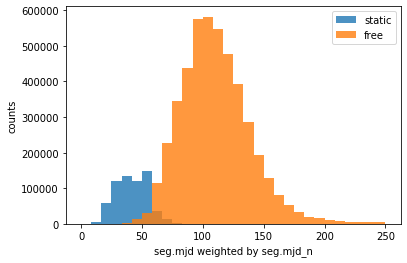

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv
static : 18590 localizations, 1142 unique tracks
free : 298631 localizations, 50907 unique tracks
min_len: 4
Sum for static = 954591.0
Sum for free = 3286342.0


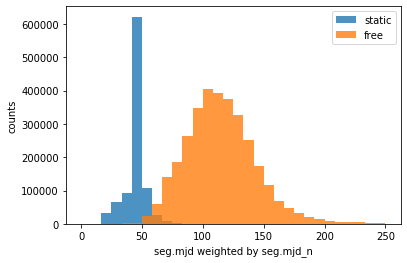

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_2/_TSrec/tracking_60ms_488nm_2_MMStack_Pos0_TSlocs.tracked.csv
static : 14330 localizations, 1014 unique tracks
free : 250993 localizations, 43664 unique tracks
min_len: 4
Sum for static = 341471.0
Sum for free = 3080921.0


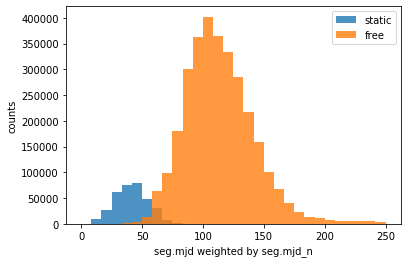

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_3/_TSrec/tracking_60ms_488nm_3_MMStack_Pos0_TSlocs.tracked.csv
static : 22869 localizations, 1443 unique tracks
free : 286201 localizations, 45797 unique tracks
min_len: 4
Sum for static = 583329.0
Sum for free = 3382265.0


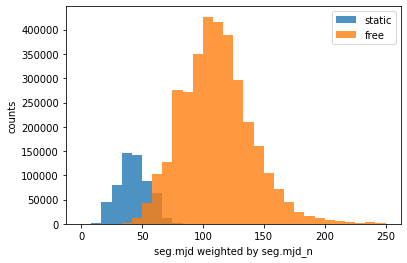

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_4/_TSrec/tracking_60ms_488nm_4_MMStack_Pos0_TSlocs.tracked.csv
static : 22749 localizations, 1402 unique tracks
free : 323141 localizations, 57389 unique tracks
min_len: 4
Sum for static = 642362.0
Sum for free = 3365974.0


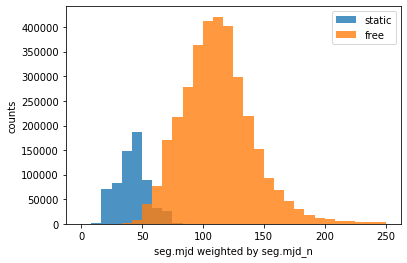

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_5/_TSrec/tracking_60ms_488nm_5_MMStack_Pos0_TSlocs.tracked.csv
static : 15519 localizations, 947 unique tracks
free : 276510 localizations, 53269 unique tracks
min_len: 4
Sum for static = 528606.0
Sum for free = 2551383.0


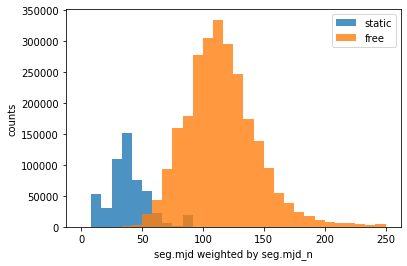

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_6/_TSrec/tracking_60ms_488nm_6_MMStack_Pos0_TSlocs.tracked.csv
static : 14538 localizations, 903 unique tracks
free : 255885 localizations, 46167 unique tracks
min_len: 4
Sum for static = 379655.0
Sum for free = 2694558.0


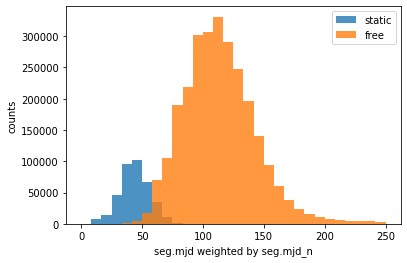

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_7/_TSrec/tracking_60ms_488nm_7_MMStack_Pos0_TSlocs.tracked.csv
static : 17307 localizations, 1036 unique tracks
free : 408364 localizations, 77136 unique tracks
min_len: 4
Sum for static = 570456.0
Sum for free = 3991366.0


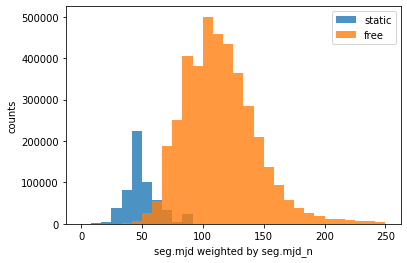

../../data/2019/0909-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.04/tracking_60ms_488nm_8/_TSrec/tracking_60ms_488nm_8_MMStack_Pos0_TSlocs.tracked.csv
static : 22228 localizations, 1336 unique tracks
free : 413091 localizations, 78798 unique tracks
min_len: 4
Sum for static = 610017.0
Sum for free = 3833023.0


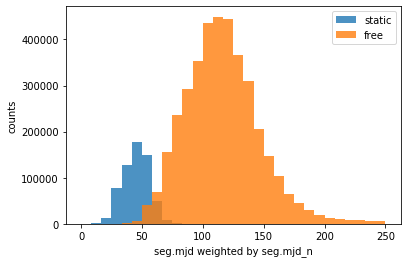

[{'static': 636217.0, 'free': 4597915.0},
 {'static': 954591.0, 'free': 3286342.0},
 {'static': 341471.0, 'free': 3080921.0},
 {'static': 583329.0, 'free': 3382265.0},
 {'static': 642362.0, 'free': 3365974.0},
 {'static': 528606.0, 'free': 2551383.0},
 {'static': 379655.0, 'free': 2694558.0},
 {'static': 570456.0, 'free': 3991366.0},
 {'static': 610017.0, 'free': 3833023.0}]

In [47]:
[swift.show_pops(d) for d in data]

In [9]:
unbinding_rates_per_second = [r['b -> u']['rate_per_second'] for r in rates]

np.mean(unbinding_rates_per_second)

0.08921147636092397

(array([2., 3., 0., 4.]),
 array([0.06600176, 0.07655303, 0.08710431, 0.09765558, 0.10820686]),
 <a list of 4 Patch objects>)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.f

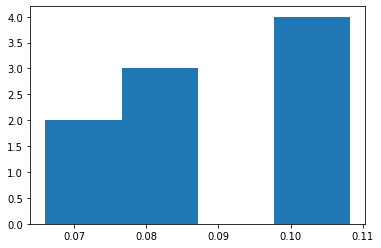

In [10]:

plt.hist(unbinding_rates_per_second, bins=4)

In [13]:
bound_fractions = [r['bound fraction'] for r in rates]
np.mean(bound_fractions)

0.05697615155386843

(array([1., 2., 4., 2.]),
 array([0.03355726, 0.04434879, 0.05514032, 0.06593185, 0.07672338]),
 <a list of 4 Patch objects>)

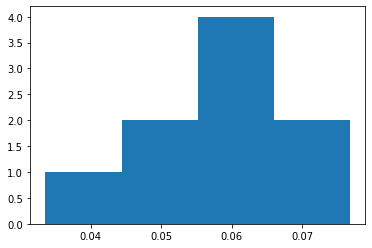

In [14]:
plt.hist(bound_fractions, bins=4)

In [15]:
data = glob('../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/*/_TSrec/*.tracked.csv')

In [156]:
stats = pd.read_json('../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/stats.json')
stats

,minutes,D_free,F_bound,num_tracks
0,9.000000,0.049392,0.226773,30457
1,11.385708,0.059485,0.142604,29637
2,13.612914,0.051620,0.193060,18209
3,18.994792,0.053639,0.256002,12851
4,21.266674,0.047250,0.186305,33012
5,23.600222,0.052566,0.164326,18024
6,27.067263,0.050680,0.189454,20075
7,29.362341,0.043813,0.221173,14365
8,124.816541,0.064641,0.145618,16722


In [16]:
data

['../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_2/_TSrec/tracking_60ms_488nm_2_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_3/_TSrec/tracking_60ms_488nm_3_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_4/_TSrec/tracking_60ms_488nm_4_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_5/_TSrec/tracking_60ms_488nm_5_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_6/_TSrec/tracking_60ms_488nm_6_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/trackin

In [17]:
p = lambda path: swift.process_switching_rate(path, frame_rate=15)
rates = list(map(p, data))

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv
static : 40315 localizations, 2612 unique tracks
free : 356594 localizations, 64278 unique tracks
min_len: 4
40315 localizations
2612 unique  seg.id
2611  tracks grouped with exp time 60 ms and lengths between 3 and inf
276046 localizations
29681 unique  seg.id
29680  tracks grouped with exp time 60 ms and lengths between 3 and inf
b -> u : 156,          per 37704 bound locs, i.e.             unbinding rate 4.14E-03 per frame
6.2E-02 per second
u -> b : 70,  per 246366 diffusive locs, i.e. binding rate 2.84E-04.
4.3E-03 per second
bound fraction = 6.4%
../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_2/_TSrec/tracking_60ms_488nm_2_MMStack_Pos0_TSlocs.tracked.csv
static : 29364 localizations, 1937 unique tracks
free : 390330 localizations, 71755 unique tracks
min_len: 4
29364 localizations
1937 unique 

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv
static : 40315 localizations, 2612 unique tracks
free : 356594 localizations, 64278 unique tracks
min_len: 4
Sum for static = 1232722.0
Sum for free = 4142320.0


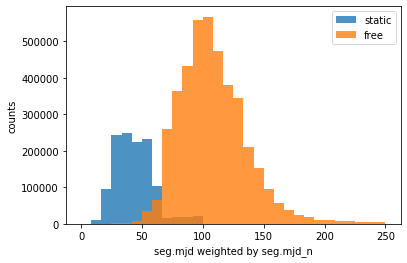

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_2/_TSrec/tracking_60ms_488nm_2_MMStack_Pos0_TSlocs.tracked.csv
static : 29364 localizations, 1937 unique tracks
free : 390330 localizations, 71755 unique tracks
min_len: 4
Sum for static = 1064336.0
Sum for free = 3985720.0


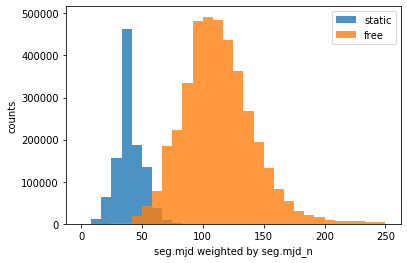

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_3/_TSrec/tracking_60ms_488nm_3_MMStack_Pos0_TSlocs.tracked.csv
static : 33237 localizations, 2076 unique tracks
free : 352883 localizations, 66049 unique tracks
min_len: 4
Sum for static = 1116047.0
Sum for free = 3280857.0


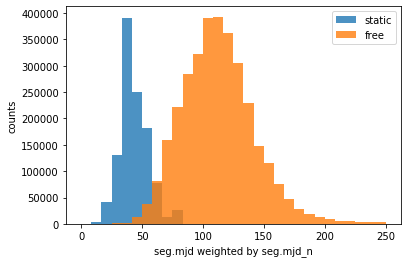

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_4/_TSrec/tracking_60ms_488nm_4_MMStack_Pos0_TSlocs.tracked.csv
static : 38310 localizations, 2432 unique tracks
free : 287469 localizations, 58158 unique tracks
min_len: 4
Sum for static = 1421893.0
Sum for free = 2608624.0


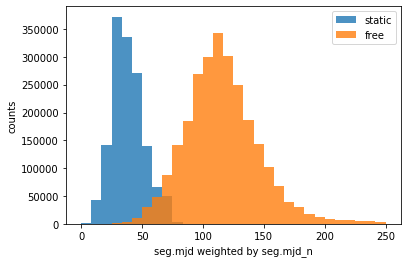

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_5/_TSrec/tracking_60ms_488nm_5_MMStack_Pos0_TSlocs.tracked.csv
static : 34563 localizations, 2204 unique tracks
free : 753469 localizations, 148538 unique tracks
min_len: 4
Sum for static = 1132459.0
Sum for free = 6538862.0


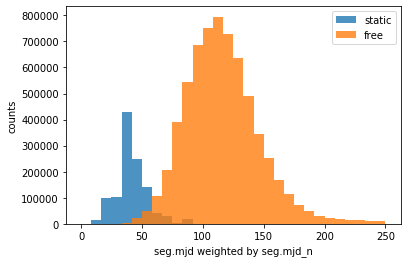

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_6/_TSrec/tracking_60ms_488nm_6_MMStack_Pos0_TSlocs.tracked.csv
static : 29742 localizations, 1914 unique tracks
free : 388854 localizations, 72275 unique tracks
min_len: 4
Sum for static = 736996.0
Sum for free = 3741190.0


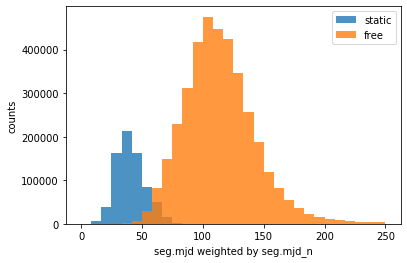

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_7/_TSrec/tracking_60ms_488nm_7_MMStack_Pos0_TSlocs.tracked.csv
static : 30111 localizations, 1851 unique tracks
free : 469602 localizations, 93765 unique tracks
min_len: 4
Sum for static = 1223884.0
Sum for free = 4143158.0


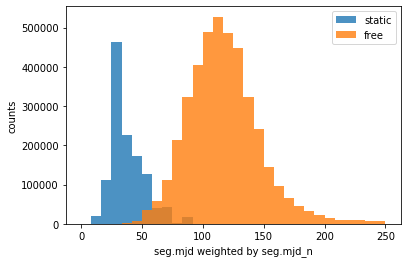

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_8/_TSrec/tracking_60ms_488nm_8_MMStack_Pos0_TSlocs.tracked.csv
static : 28302 localizations, 1720 unique tracks
free : 375478 localizations, 75607 unique tracks
min_len: 4
Sum for static = 910495.0
Sum for free = 4146126.0


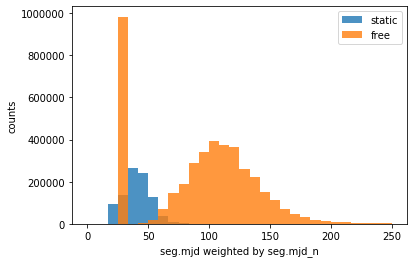

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_EPI_1/_TSrec/tracking_60ms_488nm_EPI_1_MMStack_Pos0_TSlocs.tracked.csv
static : 18409 localizations, 1204 unique tracks
free : 290833 localizations, 61819 unique tracks
min_len: 4
Sum for static = 637920.0
Sum for free = 2548988.0


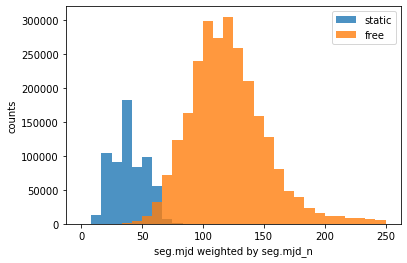

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_EPI_2/_TSrec/tracking_60ms_488nm_EPI_2_MMStack_Pos0_TSlocs.tracked.csv
static : 13730 localizations, 939 unique tracks
free : 728482 localizations, 131552 unique tracks
min_len: 4
Sum for static = 562203.0
Sum for free = 8414913.0


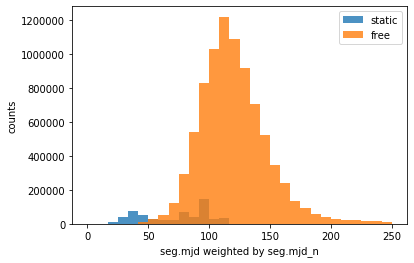

../../data/2019/0909-AV51-diff-dCas9/S2-5-5-overexpr-OD_0.05-15h10/tracking_60ms_488nm_EPI_3/_TSrec/tracking_60ms_488nm_EPI_3_MMStack_Pos0_TSlocs.tracked.csv
static : 24697 localizations, 1608 unique tracks
free : 427103 localizations, 79003 unique tracks
min_len: 4
Sum for static = 837645.0
Sum for free = 4521618.0


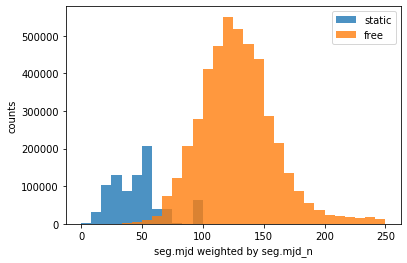

[{'static': 1232722.0, 'free': 4142320.0},
 {'static': 1064336.0, 'free': 3985720.0},
 {'static': 1116047.0, 'free': 3280857.0},
 {'static': 1421893.0, 'free': 2608624.0},
 {'static': 1132459.0, 'free': 6538862.0},
 {'static': 736996.0, 'free': 3741190.0},
 {'static': 1223884.0, 'free': 4143158.0},
 {'static': 910495.0, 'free': 4146126.0},
 {'static': 637920.0, 'free': 2548988.0},
 {'static': 562203.0, 'free': 8414913.0},
 {'static': 837645.0, 'free': 4521618.0}]

In [18]:
[swift.show_pops(d) for d in data]

In [19]:
unbinding_rates_per_second = [r['b -> u']['rate_per_second'] for r in rates]

np.mean(unbinding_rates_per_second)

0.06583265817049845

Text(0.5, 1.0, 'unbundung rates per second')

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.f

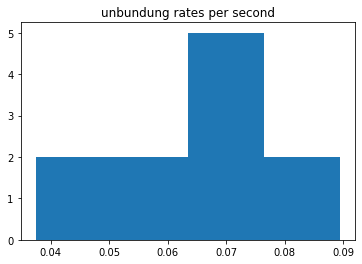

In [20]:
import matplotlib.pyplot as plt
plt.hist(unbinding_rates_per_second, bins=4)
plt.title('unbundung rates per second')

In [23]:
bound_fractions = [r['bound fraction'] for r in rates]
np.mean(bound_fractions)

0.053279893741366095

(array([3., 1., 4., 3.]),
 array([0.01162207, 0.03030307, 0.04898407, 0.06766507, 0.08634607]),
 <a list of 4 Patch objects>)

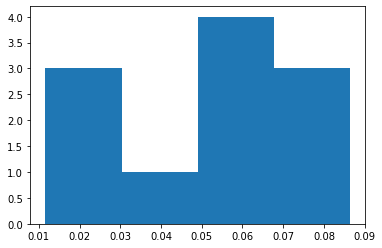

In [22]:
plt.hist(bound_fractions, bins=4)

In [24]:
data = glob('../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/*/_TSrec/*.tracked.csv')

In [25]:
data

['../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/tracking_60ms_488nm_2/_TSrec/tracking_60ms_488nm_2_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/tracking_60ms_488nm_3/_TSrec/tracking_60ms_488nm_3_MMStack_Pos0_TSlocs.tracked.csv']

In [26]:
p = lambda path: swift.process_switching_rate(path, frame_rate=15)
rates = list(map(p, data))

../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv
static : 12924 localizations, 915 unique tracks
free : 125839 localizations, 19602 unique tracks
min_len: 4
12924 localizations
915 unique  seg.id
914  tracks grouped with exp time 60 ms and lengths between 3 and inf
101941 localizations
9253 unique  seg.id
9252  tracks grouped with exp time 60 ms and lengths between 3 and inf
b -> u : 75,          per 12010 bound locs, i.e.             unbinding rate 6.24E-03 per frame
9.4E-02 per second
u -> b : 70,  per 92689 diffusive locs, i.e. binding rate 7.55E-04.
1.1E-02 per second
bound fraction = 10.8%
../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/tracking_60ms_488nm_2/_TSrec/tracking_60ms_488nm_2_MMStack_Pos0_TSlocs.tracked.csv
static : 12738 localizations, 991 unique tracks
free : 162120 localizations, 28504 unique tracks
min_len: 4
12738 localizations
991 unique  seg.id


../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/tracking_60ms_488nm_1/_TSrec/tracking_60ms_488nm_1_MMStack_Pos0_TSlocs.tracked.csv
static : 12924 localizations, 915 unique tracks
free : 125839 localizations, 19602 unique tracks
min_len: 4
Sum for static = 306225.0
Sum for free = 1925613.0


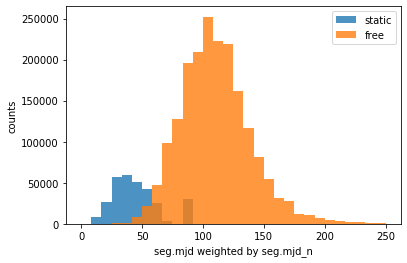

../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/tracking_60ms_488nm_2/_TSrec/tracking_60ms_488nm_2_MMStack_Pos0_TSlocs.tracked.csv
static : 12738 localizations, 991 unique tracks
free : 162120 localizations, 28504 unique tracks
min_len: 4
Sum for static = 263231.0
Sum for free = 1977212.0


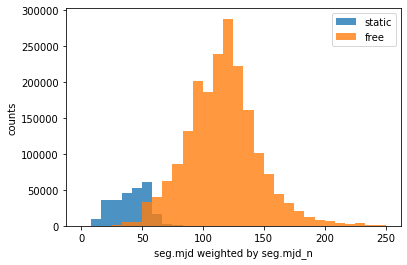

../../data/2019/0910-AV51-diff-dCas9/S1-5-5-overexpr-OD_0.13-09h35/tracking_60ms_488nm_3/_TSrec/tracking_60ms_488nm_3_MMStack_Pos0_TSlocs.tracked.csv
static : 10679 localizations, 826 unique tracks
free : 205743 localizations, 46229 unique tracks
min_len: 4
Sum for static = 279204.0
Sum for free = 1522109.0


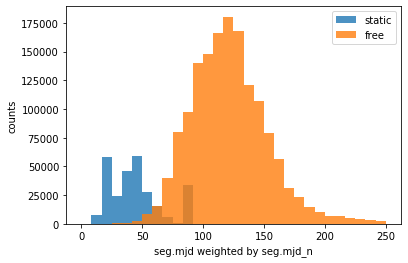

[{'static': 306225.0, 'free': 1925613.0},
 {'static': 263231.0, 'free': 1977212.0},
 {'static': 279204.0, 'free': 1522109.0}]

In [78]:
[swift.show_pops(d) for d in data]

In [27]:
unbinding_rates_per_second = [r['b -> u']['rate_per_second'] for r in rates]

np.mean(unbinding_rates_per_second)

0.0785135739028492

Text(0.5, 1.0, 'unbundung rates per second')

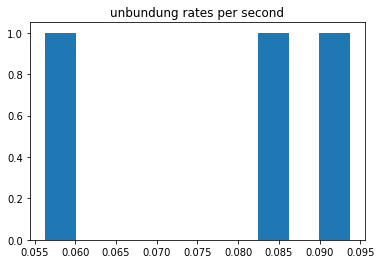

In [28]:
import matplotlib.pyplot as plt
plt.hist(unbinding_rates_per_second, bins=10)
plt.title('unbundung rates per second')

In [29]:
bound_fractions = [r['bound fraction'] for r in rates]
np.mean(bound_fractions)

0.08529109902450854

(array([1., 1., 0., 1.]),
 array([0.06518302, 0.07585914, 0.08653527, 0.09721139, 0.10788752]),
 <a list of 4 Patch objects>)

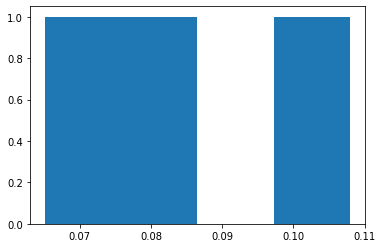

In [82]:
plt.hist(bound_fractions, bins=4)

In [30]:
data = glob('../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/*tracking*/_TSrec/*.tracked.csv')

In [31]:
data

['../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_1/_TSrec/488_tracking_60ms_1_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_10/_TSrec/488_tracking_60ms_10_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_11/_TSrec/488_tracking_60ms_11_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_12/_TSrec/488_tracking_60ms_12_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_13/_TSrec/488_tracking_60ms_13_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_14/_TSrec/488_tracking_60ms_14_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_15/_TSrec/488_tracking_60ms_15_MMStack_Pos0_TSlocs.tracked.csv',
 '../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_16/

In [32]:
p = lambda path: swift.process_switching_rate(path, frame_rate=15)
rates = list(map(p, data[9:]))

../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_18/_TSrec/488_tracking_60ms_18_MMStack_Pos0_TSlocs.tracked.csv
static : 3609 localizations, 242 unique tracks
free : 145758 localizations, 25090 unique tracks
min_len: 4
3609 localizations
242 unique  seg.id
241  tracks grouped with exp time 60 ms and lengths between 3 and inf
115659 localizations
12218 unique  seg.id
12217  tracks grouped with exp time 60 ms and lengths between 3 and inf
b -> u : 22,          per 3368 bound locs, i.e.             unbinding rate 6.53E-03 per frame
9.8E-02 per second
u -> b : 5,  per 103442 diffusive locs, i.e. binding rate 4.83E-05.
7.3E-04 per second
bound fraction = 0.7%
../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_19/_TSrec/488_tracking_60ms_19_MMStack_Pos0_TSlocs.tracked.csv
static : 3874 localizations, 203 unique tracks
free : 118807 localizations, 19102 unique tracks
min_len: 4
3874 localizations
203 unique  seg.id
202  tracks grouped with exp time 60 ms and le

../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_1/_TSrec/488_tracking_60ms_1_MMStack_Pos0_TSlocs.tracked.csv
static : 1501 localizations, 79 unique tracks
free : 69055 localizations, 10887 unique tracks
min_len: 4
Sum for static = 72931.0
Sum for free = 996029.0


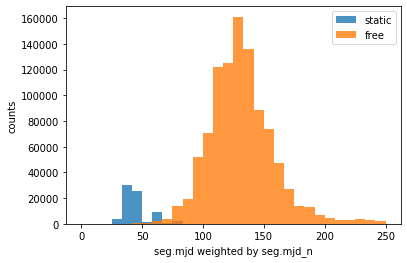

../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_10/_TSrec/488_tracking_60ms_10_MMStack_Pos0_TSlocs.tracked.csv
static : 3397 localizations, 195 unique tracks
free : 116268 localizations, 17514 unique tracks
min_len: 4
Sum for static = 98367.0
Sum for free = 1681492.0


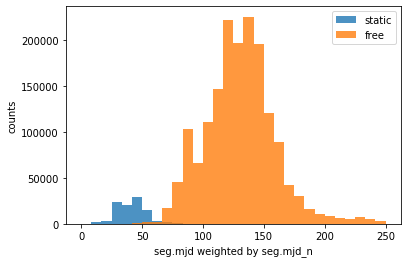

../../data/2019/0913-AV44/S1-5.5h-wt-wt-OD-0.19/488_tracking_60ms_11/_TSrec/488_tracking_60ms_11_MMStack_Pos0_TSlocs.tracked.csv
static : 1788 localizations, 125 unique tracks
free : 55786 localizations, 8767 unique tracks
min_len: 4
Sum for static = 37646.0
Sum for free = 709644.0


KeyboardInterrupt: 

In [33]:
[swift.show_pops(d) for d in data]

In [34]:
unbinding_rates_per_second = [r['b -> u']['rate_per_second'] for r in rates]

np.mean(unbinding_rates_per_second)

0.07050766556505697

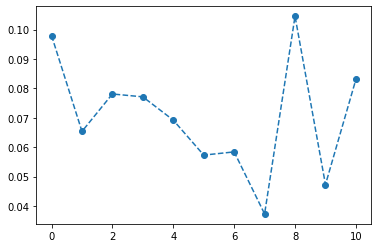

In [35]:
plt.plot(unbinding_rates_per_second, 'o--')

Text(0.5, 1.0, 'unbundung rates per second')

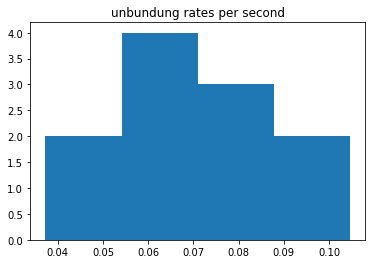

In [36]:
import matplotlib.pyplot as plt
plt.hist(unbinding_rates_per_second, bins=4)
plt.title('unbundung rates per second')

In [37]:
bound_fractions = [r['bound fraction'] for r in rates]
np.mean(bound_fractions)

0.0923931950825999

(array([3., 5., 1., 0., 0., 0., 1., 0., 0., 1.]),
 array([0.00734549, 0.04123979, 0.07513409, 0.10902839, 0.14292269,
        0.17681698, 0.21071128, 0.24460558, 0.27849988, 0.31239418,
        0.34628848]),
 <a list of 10 Patch objects>)

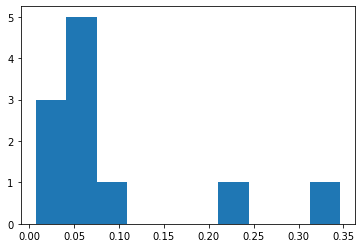

In [130]:
plt.hist(bound_fractions, bins=10)

In [131]:
α β γ δ Δ

SyntaxError: invalid syntax (<ipython-input-131-e999ede3cd3a>, line 1)